In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
    else:
        y_value = y
        y_error = [0]*len(y_value)
    plt.grid(True)
    plt.plot(x_value, y_value, "o")
    k, b = mnk_non_zero(x, y)
    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
    else:
        y_value = y
        y_error = [0]*len(y_value)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



<>:213: SyntaxWarning: invalid escape sequence '\p'
<>:216: SyntaxWarning: invalid escape sequence '\p'
<>:218: SyntaxWarning: invalid escape sequence '\p'
<>:218: SyntaxWarning: invalid escape sequence '\c'
<>:221: SyntaxWarning: invalid escape sequence '\p'
<>:213: SyntaxWarning: invalid escape sequence '\p'
<>:216: SyntaxWarning: invalid escape sequence '\p'
<>:218: SyntaxWarning: invalid escape sequence '\p'
<>:218: SyntaxWarning: invalid escape sequence '\c'
<>:221: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_22004\2701066575.py:213: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_22004\2701066575.py:216: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_22004\2701066575.py:218: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10

In [3]:
SN = DData(3000, E=-4)
l = DData(26.5, E=-2)
V = DData(1000, 10)

k, b = $1.080 \pm 0.012$ $-0.030 \pm 0.019$
$0.003600 \pm 0.000038$


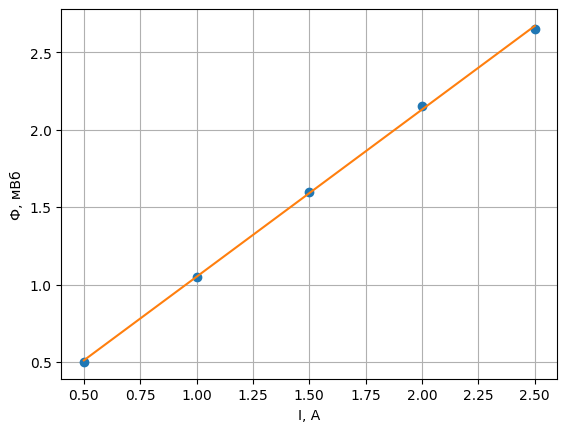

In [14]:

FI = pd.read_csv("FI.csv")
FI["F"] = (FI["F2"]-FI["F1"])/2
plt.xlabel("I, A")
plt.ylabel("Ф, мВб")
k, _ = linearcalc(FI["I"], FI["F"])
plt.savefig("FI.png", dpi=300)
BI_K = k/SN/1000
BI_K.E = 0
print(BI_K)

[0.6 5.4]
k, b = $0.002498 \pm 0.000029$ $-0.000070 \pm 0.000096$
$1.799 \pm 0.046$


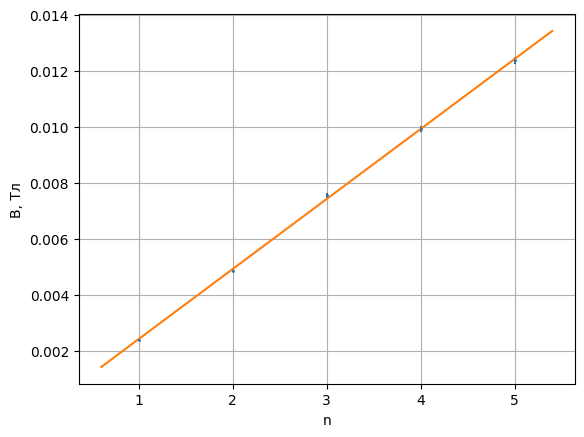

In [29]:
nF_raw = pd.read_csv("nI.csv")
nF=pd.DataFrame()
nF["n"] = [1,2,3,4,5]
I_sr = []
for i in range(1,6):
    nF_raw["I"] = nF_raw["I"].apply(lambda x: DData(x))
    I_sr.append(SerDData(nF_raw[nF_raw["n"] == i]["I"]).mean)
nF["I"] = I_sr
nF["B"] = nF["I"]*BI_K
plt.xlabel("n")
plt.ylabel("B, Тл")
Bn, _ = linearcalc_error(nF["n"], nF["B"])
plt.savefig("Bn.png", dpi = 300)
em = 8*3.14**2*V/l**2 / Bn**2
em.E = 11
print(em)


In [6]:
FI

,I,F1,F2,F
0,0.5,5.3,6.3,0.50
1,1.0,4.7,6.8,1.05
2,1.5,4.1,7.3,1.60
3,2.0,3.6,7.9,2.15
4,2.5,3.1,8.4,2.65


In [13]:
FI_out = pd.DataFrame()
FI_out["I, A"] = FI["I"]
FI_out["B1, мВб"] = FI["F1"]
FI_out["B2, мВб"] = FI["F2"]
FI_out["B, мВб"] = FI["F"]
FI_out.to_clipboard()


In [25]:
nl_out = pd.DataFrame()
nl_out["n"] = nF_raw["n"]
nl_out["I, A"] = nF_raw["I"]
nl_out["B, мТл"] = nl_out["I, A"]*BI_K
DData.changeEInSerias(nl_out["B, мТл"],-3)
nl_out.to_clipboard()
nl_out

,n,"I, A","B, мТл"
0,1,$0.7 \pm 0.0$,$2.448 \pm 0.026$
1,2,$1.4 \pm 0.0$,$4.932 \pm 0.053$
2,3,$2.1 \pm 0.0$,$7.560 \pm 0.081$
3,4,$2.8 \pm 0.0$,$9.94 \pm 0.11$
4,5,$3.5 \pm 0.0$,$12.56 \pm 0.13$
5,5,$3.4 \pm 0.0$,$12.17 \pm 0.13$
6,4,$2.8 \pm 0.0$,$9.90 \pm 0.11$
7,3,$2.1 \pm 0.0$,$7.488 \pm 0.080$
8,2,$1.4 \pm 0.0$,$5.004 \pm 0.054$
9,1,$0.7 \pm 0.0$,$2.376 \pm 0.025$
